In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '/home/ximo/Documents/GitHub/skforecast')
%config Completer.use_jedi = False

In [2]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

# Data

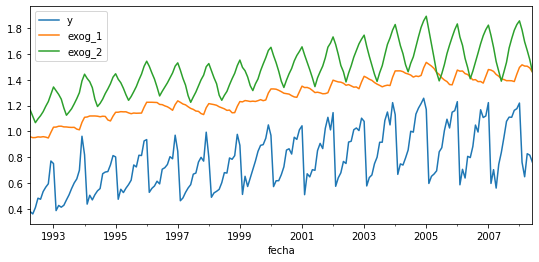

In [3]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv')
data = pd.read_csv(url, sep=',')

# data preprocessing
# ==============================================================================
data['fecha'] = pd.to_datetime(data['fecha'], format='%Y/%m/%d')
data = data.set_index('fecha')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.plot(ax=ax);

# Split train-test
# ==============================================================================
steps = 36
data_train = data.iloc[:-steps, :]
data_test  = data.iloc[-steps:, :]

# ForecasterAutoregMultiOutput without exogenous variables

In [4]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = make_pipeline(StandardScaler(), Ridge()),
                    steps     = 36,
                    lags      = 10
                )

forecaster.fit(data_train.y)
forecaster

ForecasterAutoregMultiOutput 
Regressor: Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())]) 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Window size: 10 
Maximum steps predicted: 36 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'> 
Training index frequency: MS 
Regressor parameters: {'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'ridge__alpha': 1.0, 'ridge__copy_X': True, 'ridge__fit_intercept': True, 'ridge__max_iter': None, 'ridge__normalize': 'deprecated', 'ridge__positive': False, 'ridge__random_state': None, 'ridge__solver': 'auto', 'ridge__tol': 0.001} 

Test error (mse): 0.010462358038493989


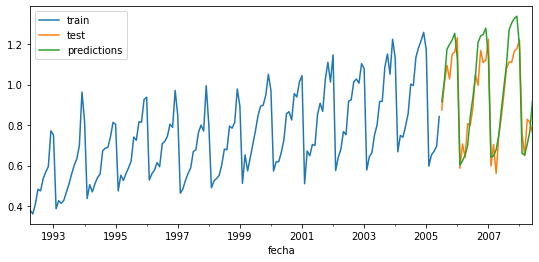

In [5]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=36)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test.y,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.y.plot(ax=ax, label='train')
data_test.y.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [6]:
# Grid search hiperparameters and lags
# ==============================================================================
steps = 36
regressor = Ridge()

forecaster = ForecasterAutoregMultiOutput(
                regressor = regressor,
                steps     = steps,
                lags      = 5 
             )

# Regressor hiperparameters
param_grid ={'alpha': [0.01, 0.1, 1]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data.y,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = steps,
                        metric      = 'mean_squared_error',
                        refit       = False,
                        initial_train_size  = int(len(data)*0.5),
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid.head(4)

Number of models compared: 9


loop lags_grid: 100%|█████████████████████████████| 3/3 [00:01<00:00,  2.35it/s]


Refitting `forecaster` using the best found parameters and the whole data set: 
  lags: [ 1  2  3  4  5  6  7  8  9 10] 
  params: {'alpha': 0.01}



,lags,params,metric,alpha
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'alpha': 0.01},0.031320,0.01
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'alpha': 0.1},0.032115,0.10
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{'alpha': 1},0.041186,1.00
8,"[1, 2, 3, 20]",{'alpha': 1},0.076195,1.00


In [7]:
# Predictors importance
# ==============================================================================
# for step in range(forecaster.steps):
#     print("Feature importance model step: ", step+1)
#     display(forecaster.get_coef(step=step+1))
#     print("")

Number of observations used for training or as initial window: 115
Number of observations used for backtesting: 80
    Number of folds: 2
    Number of steps per fold: 65
    Last fold only includes 15 observations
[0.02946123]


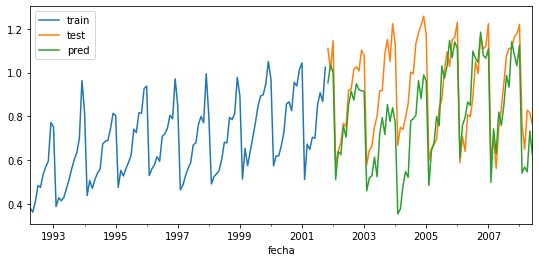

In [8]:
# Backtesting
# ==============================================================================
steps = 65
n_backtest = 40*2
data_train = data[:-n_backtest]
data_test  = data[-n_backtest:]


forecaster = ForecasterAutoregMultiOutput(
                    regressor = LinearRegression(),
                    steps     = steps,
                    lags      = 15
             )

metrica, predicciones_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = data.y,
    initial_train_size = len(data_train),
    steps      = steps,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = True
)
print(metrica)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train.y.plot(ax=ax, label='train')
data_test.y.plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predictions')
ax.legend();

In [9]:
predicciones_backtest

,pred
2001-11-01,0.952475
2001-12-01,1.034850
2002-01-01,1.001239
2002-02-01,0.510238
2002-03-01,0.639579
...,...
2008-02-01,0.540224
2008-03-01,0.568002
2008-04-01,0.545885
2008-05-01,0.732472


In [10]:
forecaster.fit(y=data_train.y)
predictions_1 = forecaster.predict(steps=steps)
predictions_2 = forecaster.predict(steps=15, last_window=data_test.y[:steps])
np.allclose(predicciones_backtest.pred, np.concatenate([predictions_1, predictions_2]))

True

# ForecasterAutoregMultiOutput with 1 exogenous variables

In [11]:
# Split train-test
# ==============================================================================
steps = 36
data_train = data.iloc[:-steps, :]
data_test  = data.iloc[-steps:, :]

In [12]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = Ridge(),
                    steps     = 36,
                    lags      = 10
                )

forecaster.fit(y=data_train.y, exog=data_train.exog_1)
forecaster

ForecasterAutoregMultiOutput 
Regressor: Ridge() 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Window size: 10 
Maximum steps predicted: 36 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: exog_1 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'> 
Training index frequency: MS 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001} 

Test error (mse): 0.00810760566140999


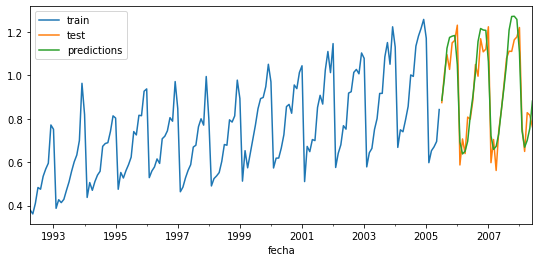

In [13]:
# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=data_test.exog_1)

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.y.plot(ax=ax, label='train')
data_test.y.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Error prediction
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test.y,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

In [14]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = RandomForestRegressor(random_state=123),
                    steps     = 36,
                    lags      = 10
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train.y,
                        exog        = data_train.exog_1,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 36,
                        metric      = 'mean_squared_error',
                        refit       = False,
                        initial_train_size = int(len(data_train)*0.5),
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid.head(4)

Number of models compared: 12


loop lags_grid: 100%|█████████████████████████████| 3/3 [00:37<00:00, 12.61s/it]


Refitting `forecaster` using the best found parameters and the whole data set: 
  lags: [ 1  2  3  4  5  6  7  8  9 10] 
  params: {'max_depth': 10, 'n_estimators': 100}



,lags,params,metric,max_depth,n_estimators
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.042035,10,100
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.042439,5,100
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.042818,10,50
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.042879,5,50


In [15]:
# Backtesting
# ==============================================================================
steps = 36
n_backtest = 36 * 3
data_train = data[:-n_backtest]
data_test  = data[-n_backtest:]

forecaster = ForecasterAutoregMultiOutput(
                regressor = Ridge(),
                steps     = steps,
                lags      = 5 
             )


metrica, predicciones_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = data.y,
    exog       = data.exog_1,
    initial_train_size = len(data_train),
    steps      = steps,
    metric     = 'mean_squared_error',
    verbose    = True
)

print(metrica)

Number of observations used for training or as initial window: 87
Number of observations used for backtesting: 108
    Number of folds: 3
    Number of steps per fold: 36
[0.09317934]


In [16]:
# Verificar predicciones de backtesting
forecaster.fit(y=data_train.y, exog=data_train.exog_1)
predictions_1 = forecaster.predict(steps=steps, exog=data_test.exog_1[:steps])
predictions_2 = forecaster.predict(steps=steps, last_window=data_test.y[:steps], exog=data_test.exog_1[steps:steps*2])
predictions_3 = forecaster.predict(steps=steps, last_window=data_test.y[steps:steps*2], exog=data_test.exog_1[steps*2:steps*3])
np.allclose(predicciones_backtest.pred, np.concatenate([predictions_1, predictions_2, predictions_3]))

True

# ForecasterAutoregMultiOutput with multiple exogenous variables

In [17]:
# Split train-test
# ==============================================================================
steps = 36
data_train = data.iloc[:-steps, :]
data_test  = data.iloc[-steps:, :]

In [18]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = RandomForestRegressor(),
                    steps     = 36,
                    lags      = 10
                )

forecaster.fit(y=data_train['y'], exog=data_train[['exog_1', 'exog_2']])
forecaster

ForecasterAutoregMultiOutput 
Regressor: RandomForestRegressor() 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Window size: 10 
Maximum steps predicted: 36 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['exog_1', 'exog_2'] 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'> 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False} 

Test error (mse): 0.005150948334734726


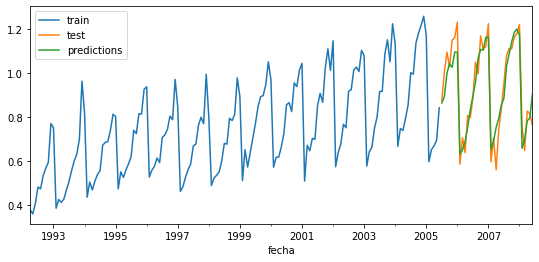

In [19]:
# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=data_test[['exog_1', 'exog_2']])

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.y.plot(ax=ax, label='train')
data_test.y.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test.y,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

In [20]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = RandomForestRegressor(),
                    steps     = 36,
                    lags      = 10
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train['y'],
                        exog        = data_train[['exog_1', 'exog_2']],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 36,
                        metric      = 'mean_squared_error',
                        refit       = False,
                        initial_train_size    = int(len(data_train)*0.5),
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

Number of models compared: 12


loop lags_grid: 100%|█████████████████████████████| 3/3 [00:34<00:00, 11.57s/it]


Refitting `forecaster` using the best found parameters and the whole data set: 
  lags: [ 1  2  3  4  5  6  7  8  9 10] 
  params: {'max_depth': 5, 'n_estimators': 50}



,lags,params,metric,max_depth,n_estimators
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.035816,5,50
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.036027,10,50
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.037080,5,100
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.037862,10,100
10,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 50}",0.038968,10,50
8,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 50}",0.039511,5,50
9,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 100}",0.039830,5,100
11,"[1, 2, 3, 20]","{'max_depth': 10, 'n_estimators': 100}",0.040085,10,100
2,"[1, 2, 3]","{'max_depth': 10, 'n_estimators': 50}",0.044048,10,50
1,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 100}",0.045315,5,100


# Unit testing

In [42]:
# Unit test create_train_X_y
# ==============================================================================

import pytest
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from sklearn.linear_model import LinearRegression

def test_create_train_X_y_output_when_lags_3_steps_1_and_exog_is_None():
    '''
    Test output of create_train_X_y when regressor is LinearRegression, lags is 3
    and steps is 1.
    '''
    forecaster = ForecasterAutoregMultiOutput(LinearRegression(), lags=3, steps=1)
    results = forecaster.create_train_X_y(y=pd.Series(np.arange(10)))
    expected = (pd.DataFrame(
                    data = np.array([[2., 1., 0.],
                                    [3., 2., 1.],
                                    [4., 3., 2.],
                                    [5., 4., 3.],
                                    [6., 5., 4.],
                                    [7., 6., 5.],
                                    [8., 7., 6.]]),
                    index   = np.array([3, 4, 5, 6, 7, 8, 9]),
                    columns = ['lag_1', 'lag_2', 'lag_3']
                ),
                pd.DataFrame(
                    np.array([3., 4., 5., 6., 7., 8., 9.]),
                    index = np.array([3, 4, 5, 6, 7, 8, 9]),
                    columns = ['y_step_0'])
               )  
 
    pd.testing.assert_frame_equal(results[0], expected[0])
    pd.testing.assert_frame_equal(results[1], expected[1])


def test_create_train_X_y_output_when_lags_3_steps_2_and_exog_is_None():
    '''
    Test output of create_train_X_y when regressor is LinearRegression, lags is 3
    and steps is 1.
    '''
    forecaster = ForecasterAutoregMultiOutput(LinearRegression(), lags=3, steps=2)
    results = forecaster.create_train_X_y(y=pd.Series(np.arange(10)))
    expected = (pd.DataFrame(
                    data = np.array([[2., 1., 0.],
                                    [3., 2., 1.],
                                    [4., 3., 2.],
                                    [5., 4., 3.],
                                    [6., 5., 4.],
                                    [7., 6., 5.]]),
                    index   = np.array([4, 5, 6, 7, 8, 9]),
                    columns = ['lag_1', 'lag_2', 'lag_3']
                ),
                pd.DataFrame(
                    np.array([[3., 4.],
                             [4., 5.],
                             [5., 6.],
                             [6., 7.],
                             [7., 8.],
                             [8., 9.]]),
                    index = np.array([4, 5, 6, 7, 8, 9]),
                    columns = ['y_step_0', 'y_step_1'])
               )  
 
    pd.testing.assert_frame_equal(results[0], expected[0])
    pd.testing.assert_frame_equal(results[1], expected[1])
    
    

def test_create_train_X_y_output_when_lags_5_steps_1_y_is_range_10_and_exog_is_1d_array():

    forecaster = ForecasterAutoregMultiOutput(LinearRegression(), lags=5, steps=1)
    results = forecaster.create_train_X_y(y=np.arange(10), exog=np.arange(100, 110))
    expected = (np.array([[4.,   3.,   2.,   1.,   0., 105.],
                         [5.,   4.,   3.,   2.,   1., 106.],
                         [6.,   5.,   4.,   3.,   2., 107.],
                         [7.,   6.,   5.,   4.,   3., 108.],
                         [8.,   7.,   6.,   5.,   4., 109.]]),
                np.array([[5.],
                         [6.],
                         [7.],
                         [8.],
                         [9.]]))     

    assert (results[0] == expected[0]).all()
    assert (results[1] == expected[1]).all()


def test_create_train_X_y_output_when_lags_5_steps_2_y_is_range_10_and_exog_is_1d_array():

    forecaster = ForecasterAutoregMultiOutput(LinearRegression(), lags=5, steps=2)
    results = forecaster.create_train_X_y(y=np.arange(10), exog=np.arange(100, 110))
    expected = (np.array([[  4.,   3.,   2.,   1.,   0., 105., 106.],
                        [  5.,   4.,   3.,   2.,   1., 106., 107.],
                        [  6.,   5.,   4.,   3.,   2., 107., 108.],
                        [  7.,   6.,   5.,   4.,   3., 108., 109.]]),
                np.array([[5., 6.],
                        [6., 7.],
                        [7., 8.],
                        [8., 9.]]))   

    assert (results[0] == expected[0]).all()
    assert (results[1] == expected[1]).all()


def test_create_train_X_y_output_when_lags_5_steps_1_y_is_range_10_and_exog_is_2d_array():

    forecaster = ForecasterAutoregMultiOutput(LinearRegression(), lags=5, steps=1)
    results = forecaster.create_train_X_y(
            y=np.arange(10),
            exog=np.column_stack([np.arange(100, 110), np.arange(1000, 1010)])
          )
    expected = (np.array([[4,    3,    2,    1,    0,  105, 1005],
                        [5,    4,    3,    2,    1,  106, 1006],
                        [6,    5,    4,    3,    2,  107, 1007],
                        [7,    6,    5,    4,    3,  108, 1008],
                        [8,    7,    6,    5,    4,  109, 1009]]),
                np.array([[5.],
                         [6.],
                         [7.],
                         [8.],
                         [9.]]))     

    assert (results[0] == expected[0]).all()
    assert (results[1] == expected[1]).all()

def test_create_train_X_y_output_when_lags_5_steps_3_y_is_range_10_and_exog_is_2d_array():

    forecaster = ForecasterAutoregMultiOutput(LinearRegression(), lags=5, steps=3)
    results = forecaster.create_train_X_y(
            y=np.arange(10),
            exog=np.column_stack([np.arange(100, 110), np.arange(1000, 1010)])
          )
    expected = (np.array([[   4,    3,    2,    1,    0,  105,  106,  107, 1005, 1006, 1007],
                        [   5,    4,    3,    2,    1,  106,  107,  108, 1006, 1007, 1008],
                        [   6,    5,    4,    3,    2,  107,  108,  109, 1007, 1008, 1009]]),
                np.array([[5, 6, 7],
                         [6, 7, 8],
                         [7, 8, 9]]))     

    assert (results[0] == expected[0]).all()
    assert (results[1] == expected[1]).all()

In [43]:
test_create_train_X_y_output_when_lags_3_steps_1_and_exog_is_None()
test_create_train_X_y_output_when_lags_3_steps_2_and_exog_is_None()

In [21]:
import session_info
session_info.show(html=False, write_req_file=False)

-----
matplotlib          3.4.3
numpy               1.19.5
pandas              1.2.5
session_info        1.0.0
skforecast          0.4.dev
sklearn             1.0.1
-----
IPython             7.26.0
jupyter_client      6.1.7
jupyter_core        4.6.3
jupyterlab          2.1.3
notebook            6.4.0
-----
Python 3.7.9 (default, Aug 31 2020, 12:42:55) [GCC 7.3.0]
Linux-5.11.0-40-generic-x86_64-with-debian-bullseye-sid
-----
Session information updated at 2021-11-24 23:00
